 Install Required Libraries

In [1]:
!pip install numpy pandas matplotlib seaborn nltk gensim scikit-learn tensorflow kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 681.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 13.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
open

Download and Load the Dataset

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('Train.csv')

# Clean and standardize labels
df['label'] = df['label'].astype(str).str.lower().str.strip()
print("Label distribution:\n", df['label'].value_counts())

# Convert to numerical (handle any format variations)
label_map = {'positive': 1, 'negative': 0, '1': 1, '0': 0}
df['sentiment'] = df['label'].map(label_map)

# Remove rows with invalid labels
df = df.dropna(subset=['sentiment'])
df['sentiment'] = df['sentiment'].astype(int)
print("\nClean label distribution:\n", df['sentiment'].value_counts())

Label distribution:
 label
0    20019
1    19981
Name: count, dtype: int64

Clean label distribution:
 sentiment
0    20019
1    19981
Name: count, dtype: int64


Text preprocessing

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Process a sample for faster execution
df = df.sample(frac=0.3, random_state=42)
df['processed_text'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


TF-IDF + Logistic Regression

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'], df['sentiment'], test_size=0.2, random_state=42
)

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

lr = LogisticRegression(max_iter=500)
lr.fit(X_train_tfidf, y_train)
y_pred = lr.predict(X_test_tfidf)

print("\nTF-IDF + Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))



TF-IDF + Logistic Regression Results:
Accuracy: 0.8704
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1169
           1       0.86      0.89      0.88      1231

    accuracy                           0.87      2400
   macro avg       0.87      0.87      0.87      2400
weighted avg       0.87      0.87      0.87      2400



Word2Vec + Logistic Regression

In [10]:
import numpy as np
import gensim.downloader as api

# Use pre-trained embeddings for speed
w2v = api.load('word2vec-google-news-300')

def document_vector(doc):
    doc = [word for word in doc.split() if word in w2v.key_to_index]
    if len(doc) == 0:
        return np.zeros(300)
    return np.mean(w2v[doc], axis=0)

X_w2v = np.array([document_vector(text) for text in df['processed_text']])
y = df['sentiment']

X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
    X_w2v, y, test_size=0.2, random_state=42
)

lr_w2v = LogisticRegression(max_iter=500)
lr_w2v.fit(X_train_w2v, y_train_w2v)
y_pred_w2v = lr_w2v.predict(X_test_w2v)

print("\nWord2Vec + Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test_w2v, y_pred_w2v):.4f}")
print(classification_report(y_test_w2v, y_pred_w2v))

[==================================================] 100.0% 1662.8/1662.8MB downloaded

Word2Vec + Logistic Regression Results:
Accuracy: 0.8508
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1169
           1       0.86      0.85      0.85      1231

    accuracy                           0.85      2400
   macro avg       0.85      0.85      0.85      2400
weighted avg       0.85      0.85      0.85      2400



LSTM Model (simplified for speed)

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['processed_text'])

X = tokenizer.texts_to_sequences(df['processed_text'])
X = pad_sequences(X, maxlen=200)
y = df['sentiment']

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = Sequential([
    Embedding(5000, 64, input_length=200),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_lstm, y_train_lstm, epochs=3, batch_size=64, validation_split=0.1)

loss, accuracy = model.evaluate(X_test_lstm, y_test_lstm)
print(f"\nLSTM Model Accuracy: {accuracy:.4f}")

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - accuracy: 0.6293 - loss: 0.6209 - val_accuracy: 0.8469 - val_loss: 0.3725
Epoch 2/3
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.8903 - loss: 0.2755 - val_accuracy: 0.8385 - val_loss: 0.3626
Epoch 3/3
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.9452 - loss: 0.1788 - val_accuracy: 0.8417 - val_loss: 0.3928
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8439 - loss: 0.3994

LSTM Model Accuracy: 0.8433


Model Comparison

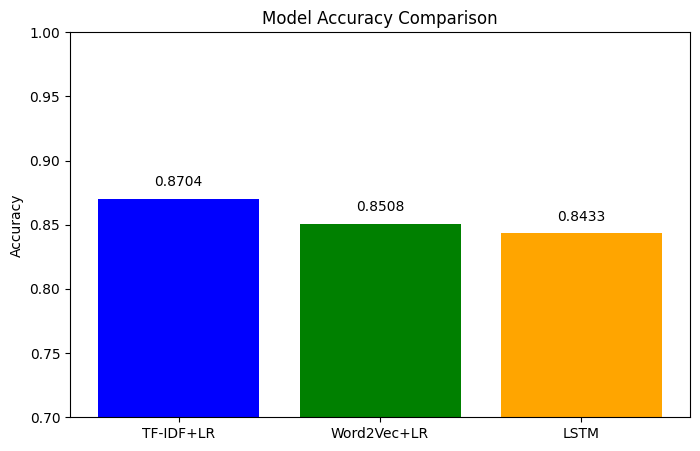

In [12]:
import matplotlib.pyplot as plt

models = ['TF-IDF+LR', 'Word2Vec+LR', 'LSTM']
accuracies = [
    accuracy_score(y_test, y_pred),
    accuracy_score(y_test_w2v, y_pred_w2v),
    accuracy
]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.ylim(0.7, 1.0)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.show()

Save the best model

In [13]:
import joblib
joblib.dump((lr, tfidf), 'best_sentiment_model.pkl')
print("\nTF-IDF + Logistic Regression model saved as 'best_sentiment_model.pkl'")


TF-IDF + Logistic Regression model saved as 'best_sentiment_model.pkl'
